# Exploring Accuracy


In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import time
import seaborn as sns 
import os
os.chdir('E:\\Google Drive\\kaggle\\03-facebook\\data')
%matplotlib inline

pal = sns.color_palette()
ftypes_train = dict(row_id=np.int32, x=np.float32, y=np.float32, accuracy=np.int32, time=np.int32, place_id=np.int64)
ftypes_test = dict(row_id=np.int32, x=np.float32, y=np.float32, accuracy=np.int32, time=np.int32)

In [2]:
df_train = pd.read_csv("train.csv", dtype=ftypes_train)
df_test = pd.read_csv("test.csv", dtype=ftypes_test)

In [3]:
# Add some time fields
df_train["hour"]       = (df_train["time"]%(60*24))//60.
df_train["dayofweek"]  = np.ceil((df_train["time"]%(60*24*7))//(60.*24))
df_train["day"]  = np.ceil((df_train["time"]/(60*24)))
df_train["week"] = np.ceil((df_train["time"]/(60*24*7)))
df_test["hour"]        = (df_test["time"]%(60*24))//60.
df_test["dayofweek"]   = np.ceil((df_test["time"]%(60*24*7))//(60.*24))
df_test["day"]   = np.ceil((df_test["time"]/(60*24)))
df_test["week"]  = np.ceil((df_test["time"]/(60*24*7)))

It's been reported elsewhere that accuracy varies as a function of time, let's quickly plot the time series, averaged in weeks.

In [4]:
# Group by week and get average/median/std dev
df_train_wkaccuracy = df_train.groupby("week").agg({"accuracy":[np.mean, np.median, np.std]}).reset_index()
df_test_wkaccuracy = df_test.groupby("week").agg({"accuracy":[np.mean, np.median, np.std]}).reset_index()
df_train_wkaccuracy.columns = ["week", "acc_mean", "acc_median", "acc_std"]
df_test_wkaccuracy.columns = ["week", "acc_mean", "acc_median", "acc_std"]
df_test_wkaccuracy.head()

,week,acc_mean,acc_median,acc_std
0,79,95.366474,64,128.908462
1,80,95.653267,65,128.163694
2,81,95.839402,65,128.441102
3,82,95.979887,65,129.359565
4,83,95.527559,65,128.265093


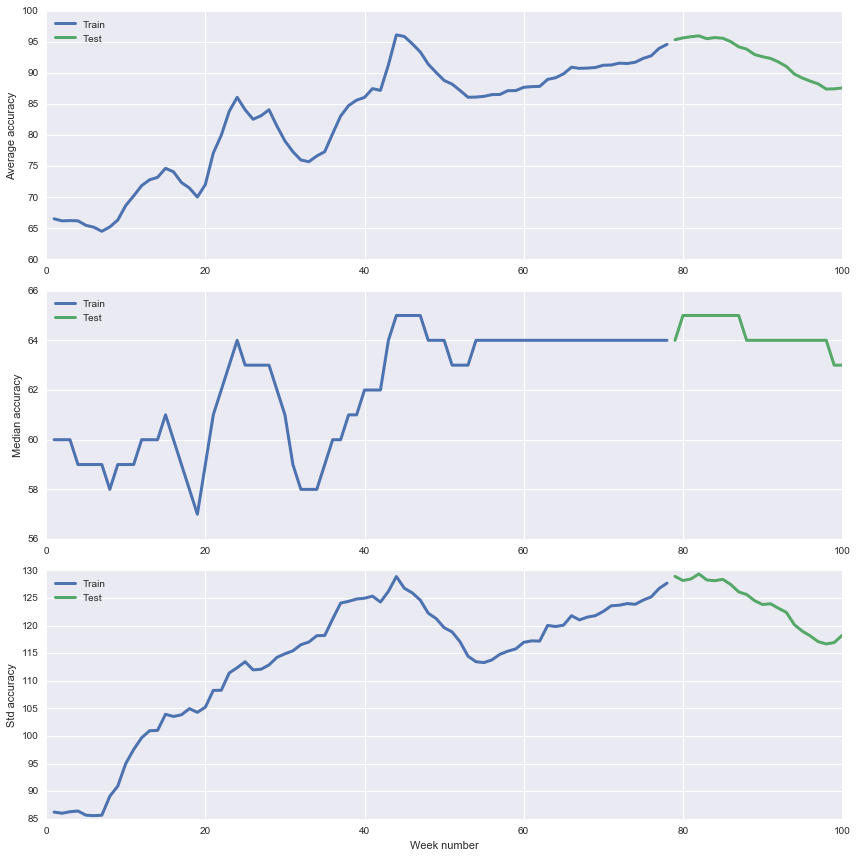

In [5]:
# Plots
x1 = df_train_wkaccuracy["week"]
y1a = df_train_wkaccuracy["acc_mean"]
y1b = df_train_wkaccuracy["acc_median"]
y1c = df_train_wkaccuracy["acc_std"]

x2 = df_test_wkaccuracy["week"]
y2a = df_test_wkaccuracy["acc_mean"]
y2b = df_test_wkaccuracy["acc_median"]
y2c = df_test_wkaccuracy["acc_std"]

plt.figure(0, figsize=(12,12))

plt.subplot(311)
plt.plot(x1, y1a, c=pal[0], lw=3, label="Train")
plt.plot(x2, y2a, c=pal[1], lw=3, label="Test")
plt.ylabel("Average accuracy")
plt.legend(loc=2)

plt.subplot(312)
plt.plot(x1, y1b, c=pal[0], lw=3, label="Train")
plt.plot(x2, y2b, c=pal[1], lw=3, label="Test")
plt.ylabel("Median accuracy")
plt.legend(loc=2)
plt.ylim(56,66)

plt.subplot(313)
plt.plot(x1, y1c, c=pal[0], lw=3, label="Train")
plt.plot(x2, y2c, c=pal[1], lw=3, label="Test")
plt.xlabel("Week number")
plt.ylabel("Std accuracy")
plt.legend(loc=2)

plt.tight_layout()
plt.show()

It's very interesting that after ~50 weeks the median accuracy flatlines at 64, with a small blip at 65, then back to 64 for the test data.  
We can also examine the distribution of accuracy closer, and find some intersting things

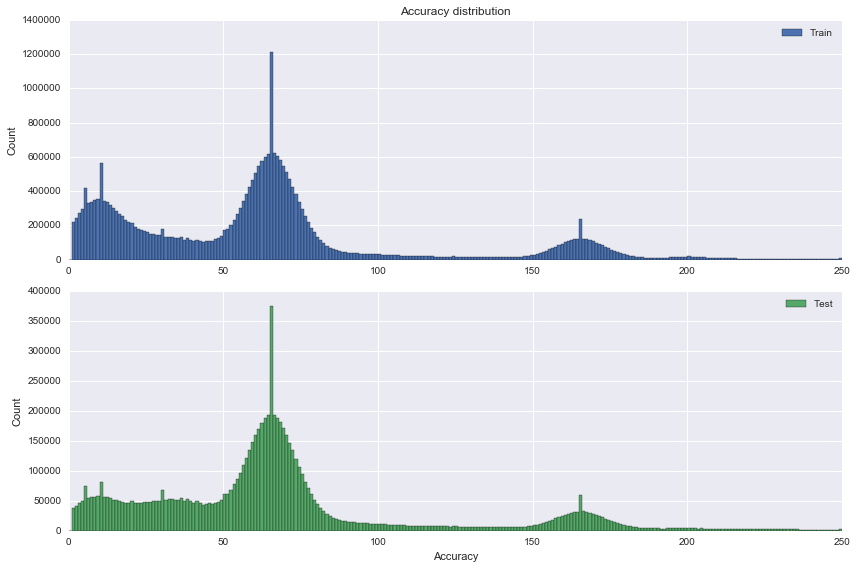

In [6]:
plt.figure(0, figsize=(12,8))

plt.subplot(211)
plt.hist(df_train["accuracy"], bins=250, range=[0,250], color=pal[0], label="Train")
plt.ylabel("Count")
plt.title("Accuracy distribution")
plt.legend()

plt.subplot(212)
plt.hist(df_test["accuracy"].values, bins=250, range=[0,250], color=pal[1], label="Test")
plt.xlabel("Accuracy")
plt.ylabel("Count")
plt.legend()

plt.tight_layout()
plt.show()

There's three main peaks, as well as 5 weird peaky outliers, let's find out what values they are at:

In [20]:
counts, bins = np.histogram(df_train["accuracy"], bins=np.arange(0.5,251.5,1), range=[1,250])
binsc = bins[:-1] + np.diff(bins)/2.
i1 = np.where(counts==counts[0:7].max())[0][0]
i2 = np.where(counts==counts[7:15].max())[0][0]
i3 = np.where(counts==counts[25:50].max())[0][0]
i4 = np.where(counts==counts[50:100].max())[0][0]
i5 = np.where(counts==counts[150:200].max())[0][0]
a1, c1 = binsc[i1], counts[i1]
a2, c2 = binsc[i2], counts[i2]
a3, c3 = binsc[i3], counts[i3]
a4, c4 = binsc[i4], counts[i4]
a5, c5 = binsc[i5], counts[i5]
print ("Peaks at:", a1, a2, a3, a4, a5)
print ("Counts are:", c1, c2, c3, c4, c5)

('Peaks at:', 5.0, 10.0, 30.0, 65.0, 165.0)
('Counts are:', 416462, 561614, 178786, 1212970, 237762)


We can define these regions and peaks, so we can investigate them independently to see if they behave differently in any ways.

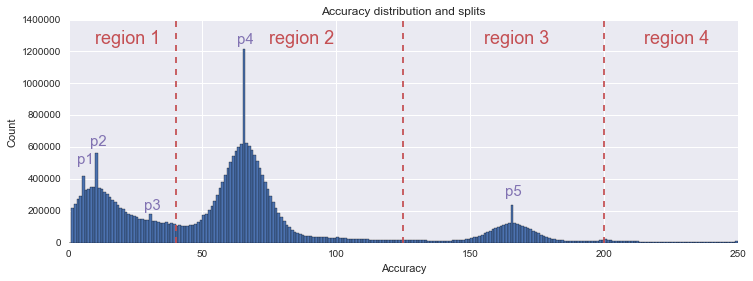

In [21]:

plt.figure(0, figsize=(12,4))
plt.hist(df_train["accuracy"].values, bins=250, range=[0,250])
plt.axvline(x=40, c=pal[2], ls='--')
plt.axvline(x=125, c=pal[2], ls='--')
plt.axvline(x=200, c=pal[2], ls='--')
plt.text(10, 1250000, "region 1", color=pal[2], size=18)
plt.text(75, 1250000, "region 2", color=pal[2], size=18)
plt.text(155, 1250000, "region 3", color=pal[2], size=18)
plt.text(215, 1250000, "region 4", color=pal[2], size=18)
plt.text(a1-2, 500000, "p1", color=pal[3], size=15)
plt.text(a2-2, 610000, "p2", color=pal[3], size=15)
plt.text(a3-2, 210000, "p3", color=pal[3], size=15)
plt.text(a4-2, 1250000, "p4", color=pal[3], size=15)
plt.text(a5-2, 300000, "p5", color=pal[3], size=15)
plt.xlabel("Accuracy")
plt.ylabel("Count")
plt.title("Accuracy distribution and splits")
plt.show()

The question is, do these different region/peaks correlate with anything else?  
Let's split the train set up into various subsets representing these regions/peaks, and see if the distribution of other variables change.  

In [22]:
# Split the accuracy up into different components, and check some distributions of other things
# Groups are the main distribution regions, and separately the weird maxima
acc_r1 = df_train[(df_train["accuracy"]>=0) & (df_train["accuracy"]<40)]
acc_r2 = df_train[(df_train["accuracy"]>=40) & (df_train["accuracy"]<125)]
acc_r3 = df_train[(df_train["accuracy"]>=125) & (df_train["accuracy"]<200)]
acc_r4 = df_train[(df_train["accuracy"]>=200)]
acc_p1 = df_train[(df_train["accuracy"]==a1)]
acc_p2 = df_train[(df_train["accuracy"]==a2)]
acc_p3 = df_train[(df_train["accuracy"]==a3)]
acc_p4 = df_train[(df_train["accuracy"]==a4)]
acc_p5 = df_train[(df_train["accuracy"]==a5)]
acc = [acc_r1, acc_r2, acc_r3, acc_r4, acc_p1, acc_p2, acc_p3, acc_p4, acc_p5]

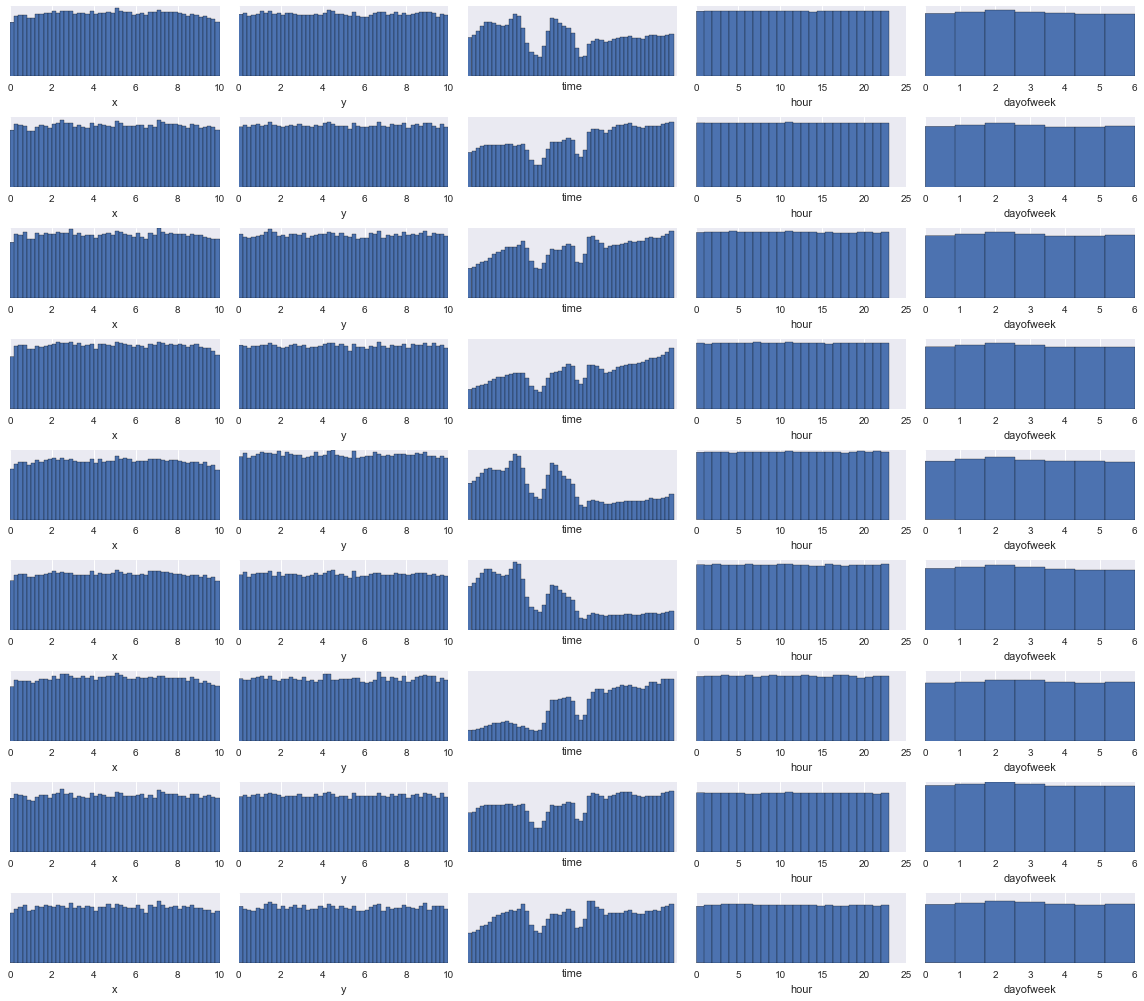

In [23]:
plt.figure(0, figsize=(16,14))
for i in range(len(acc)):
    pd_acc = acc[i]
    plt.subplot(9, 5, (i*5)+1)
    plt.hist(pd_acc["x"].values, bins=50)
    plt.xlabel("x")
    plt.gca().get_yaxis().set_ticks([]) 
    
    plt.subplot(9, 5, (i*5)+2)
    plt.hist(pd_acc["y"].values, bins=50)
    plt.xlabel("y")
    plt.gca().get_yaxis().set_ticks([]) 

    plt.subplot(9, 5, (i*5)+3)
    plt.hist(pd_acc["time"].values, bins=50)
    plt.xlabel("time")
    plt.gca().get_xaxis().set_ticks([]) 
    plt.gca().get_yaxis().set_ticks([]) 

    plt.subplot(9, 5, (i*5)+4)
    plt.hist(pd_acc["hour"].values, bins=24)
    plt.xlabel("hour")
    plt.gca().get_yaxis().set_ticks([]) 

    plt.subplot(9, 5, (i*5)+5)
    plt.hist(pd_acc["dayofweek"].values, bins=7)
    plt.xlabel("dayofweek")
    plt.gca().get_yaxis().set_ticks([]) 
    
plt.tight_layout()
plt.show()

Everything remains constant except non-cyclic time.  
Particularly interesting is that peaks 1 and 2 (the 5th and 6th rows) don't appear much at the end, but peak 3 (7th row) is the reverse.  
Let's take raw time and split it up into various even parts, and see how the accuracy distribution varies.  
For this, it might be nicer to plot density plots, and compare them against the overall distribution (represented in the following charts as the light grey shaded area).  

In [24]:
# Sample the train set for the next part
df_train_sample = df_train.sample(n=1000000)

# Check accuracy profiles as a function of time
# Split the dataset up into 8 equal parts of 100,000 minutes (~2 months)
t1 = df_train_sample[(df_train_sample["time"]>=0)      & (df_train_sample["time"]<100000)]
t2 = df_train_sample[(df_train_sample["time"]>=100000) & (df_train_sample["time"]<200000)]
t3 = df_train_sample[(df_train_sample["time"]>=200000) & (df_train_sample["time"]<300000)]
t4 = df_train_sample[(df_train_sample["time"]>=300000) & (df_train_sample["time"]<400000)]
t5 = df_train_sample[(df_train_sample["time"]>=400000) & (df_train_sample["time"]<500000)]
t6 = df_train_sample[(df_train_sample["time"]>=500000) & (df_train_sample["time"]<600000)]
t7 = df_train_sample[(df_train_sample["time"]>=600000) & (df_train_sample["time"]<700000)]
t8 = df_train_sample[(df_train_sample["time"]>=700000) & (df_train_sample["time"]<800000)]
times = [t1,t2,t3,t4,t5,t6,t7,t8]

In [25]:
# Produce density estimates
kde_t_overall = gaussian_kde(df_train_sample["accuracy"].values)
kdes = []
for t in times:
    kdes.append(gaussian_kde(t["accuracy"].values))

rangeX = np.linspace(0, 250, 100) # create from 0 to 250, total 100 number
y_overall = kde_t_overall(rangeX)
ys = []
for k in kdes:
    ys.append(k(rangeX))

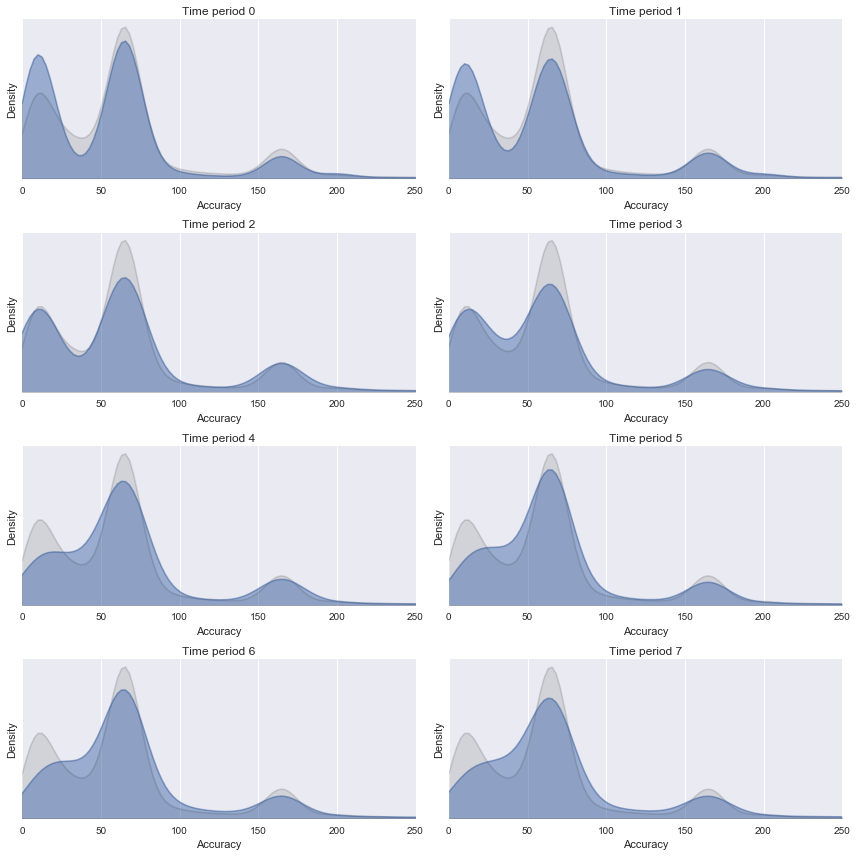

In [30]:
# Plot them
plt.figure(0, figsize=(12,12))
for i in range(8):
    plt.subplot(4,2,i+1)
    # Overall accuracy distribution
    plt.plot(rangeX, y_overall, color='k', alpha=0.1)
    plt.gca().fill_between(rangeX, 0, y_overall, facecolor='k', alpha=0.1)
    
    # Time period N distribution
    plt.plot(rangeX, ys[i], color=pal[0], alpha=0.5)
    plt.gca().fill_between(rangeX, 0, ys[i], facecolor=pal[0], alpha=0.5)
    
    plt.title("Time period " + str(i))
    plt.ylabel("Density")
    plt.xlabel("Accuracy")
    plt.gca().get_yaxis().set_ticks([])  
    
plt.tight_layout()
plt.show()

This aligns with the general statement "accuracy increases with time", but actually shows how the distribution changes with time.  
You see the biggest change is that as time progresses, region 1 (as defined above) reduces in size and the values move upward.
What does this mean though?  
Knowing accuracy distribution as a function of time (in this form) is useless for predictions...